In [69]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.plotting import plot_decision_regions
import matplotlib.gridspec as gridspec
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
import itertools
from itertools import combinations
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import plot_tree
from sklearn.tree import export_graphviz

In [2]:
apples = pd.read_csv('https://raw.githubusercontent.com/ElijahSum/mipt_visualization/master/week_03_visualization/apple_quality.csv')
apples.head()

,A_id,Size,Weight,Sweetness,Crunchiness,Juiciness,Ripeness,Acidity,Quality
0,0.0,-3.970049,-2.512336,5.346330,-1.012009,1.844900,0.329840,-0.491590483,good
1,1.0,-1.195217,-2.839257,3.664059,1.588232,0.853286,0.867530,-0.722809367,good
2,2.0,-0.292024,-1.351282,-1.738429,-0.342616,2.838636,-0.038033,2.621636473,bad
3,3.0,-0.657196,-2.271627,1.324874,-0.097875,3.637970,-3.413761,0.790723217,good
4,4.0,1.364217,-1.296612,-0.384658,-0.553006,3.030874,-1.303849,0.501984036,good


# Задача 1.1

In [14]:
for column in apples.select_dtypes(include=['float64', 'int']).columns:
    apples[column].fillna(apples[column].mean(), inplace=True)

In [15]:
def knn_two_features(df, y):
    # Отбираем все числовые признаки в датасете
    numeric_features = df.select_dtypes(include=['float64', 'int']).columns.tolist()
    
    # Инициализируем LabelEncoder для преобразования качественных переменных в числовые
    le = LabelEncoder()
    y_encoded = le.fit_transform(df[y])
    
    # Переменные для хранения лучшей пары признаков и наивысшего accuracy
    best_features = []
    best_accuracy = 0
    
    # Перебор всех сочетаний по два признака
    for features in combinations(numeric_features, 2):
        # Выбираем данные по текущей паре признаков
        X = df[list(features)]
        X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=42)
        
        # модель
        knn = KNeighborsClassifier(n_neighbors=10)
        knn.fit(X_train, y_train)
        
        # accuracy на тесте
        y_pred = knn.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        
        # Если текущая точность выше предыдущей лучшей, обновляем лучшие признаки и точность
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_features = list(features)
            
    return best_features

In [16]:
best_features_knn = knn_two_features(apples, 'Quality')
print(best_features_knn)

['Size', 'Sweetness']


Лучшей парой признаков для классификации качества яблок с использованием алгоритма kNN (k = 10) оказались `Size` и `Sweetness`. Эти признаки дали наивысший *accuracy score* среди всех возможных пар числовых признаков в датасете.

Этот результат предполагает, что размер и сладость яблок являются значимыми индикаторами их качества

# Задача 1.2

In [22]:
X = apples[['Size', 'Sweetness']].values
y = LabelEncoder().fit_transform(apples['Quality'].values)

In [23]:
k_values = [1, 2, 5, 10, 15, 20, 30, 40, 50]

KeyboardInterrupt: 

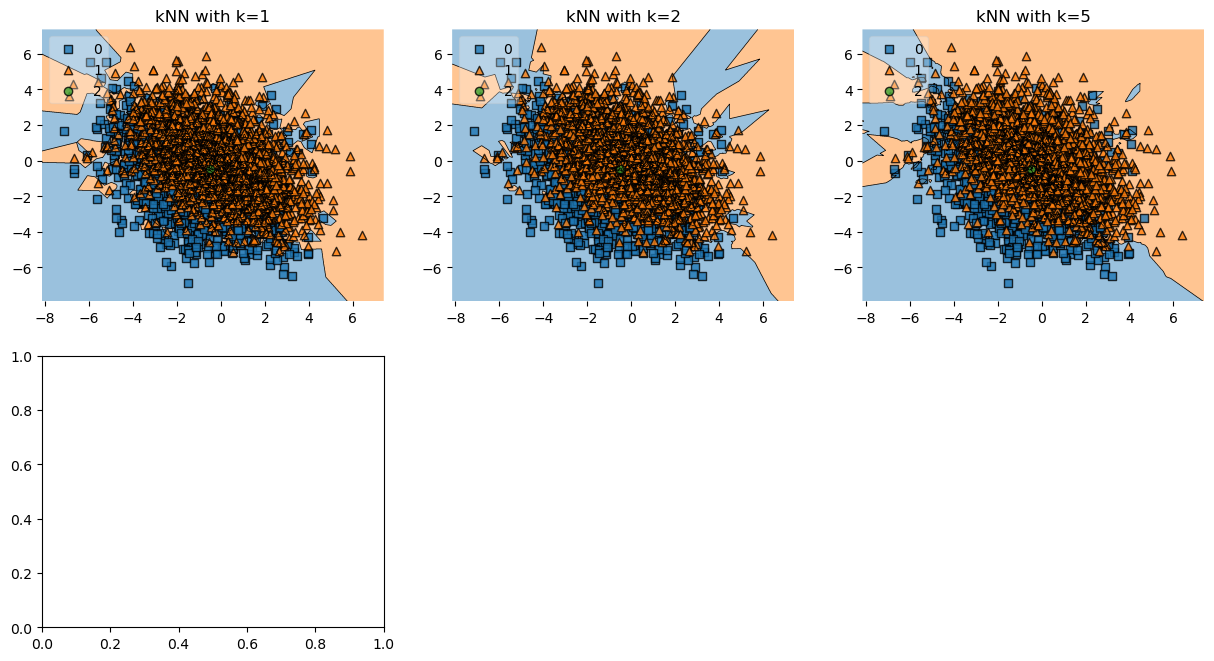

In [27]:
gs = gridspec.GridSpec(3, 3)
fig = plt.figure(figsize=(15, 12))
for k, grd in zip(k_values, itertools.product([0, 1, 2], repeat=2)):
    clf = KNeighborsClassifier(n_neighbors=k)
    clf.fit(X, y)
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=X, y=y, clf=clf, legend=2)
    plt.title(f'kNN with k={k}')

plt.show()

# Задача 1.3

In [34]:
X1 = apples[['Sweetness', 'Size',]].values
X2 = apples[['Sweetness', 'Crunchiness']].values

In [35]:
y = LabelEncoder().fit_transform(apples['Quality'].values) # Целевая переменная

In [36]:
clf1 = DecisionTreeClassifier(random_state=42).fit(X1, y)
clf2 = DecisionTreeClassifier(random_state=42).fit(X2, y)

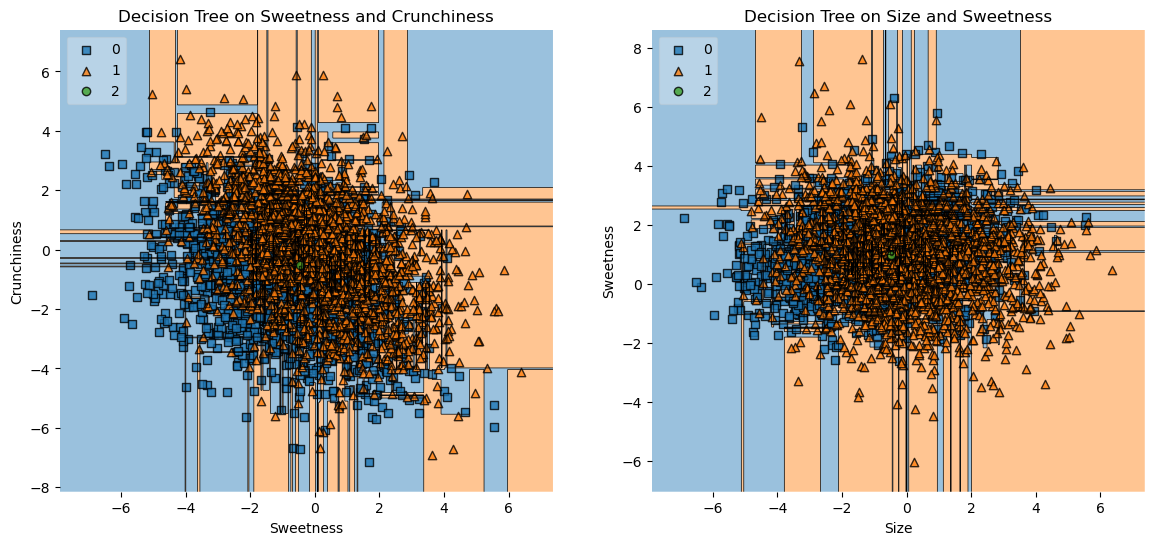

In [38]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

plot_decision_regions(X1, y, clf=clf1, legend=2, ax=ax[0])
ax[0].set_title('Decision Tree on Sweetness and Crunchiness')
ax[0].set_xlabel('Sweetness')
ax[0].set_ylabel('Crunchiness')

plot_decision_regions(X2, y, clf=clf2, legend=2, ax=ax[1])
ax[1].set_title('Decision Tree on Size and Sweetness')
ax[1].set_xlabel('Size')
ax[1].set_ylabel('Sweetness')

plt.show()

# Задача 2.1

In [39]:
def best_two_features_dt(df, y):
    """
    Возвращает два параметра, дающие наибольший accuracy score при применении алгоритма решающего дерева.
    
    :param df: DataFrame с признаками
    :param y: Строка, название столбца с целевой переменной
    :return: Список из двух названий признаков
    """
    best_accuracy = 0
    best_features = None
    
    y_encoded = LabelEncoder().fit_transform(df[y])
    features = df.drop(columns=[y]).select_dtypes(include=['number']).columns.tolist()
    
    for feature_pair in combinations(features, 2):
        X = df[list(feature_pair)]
        
        X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=42)
        
        clf = DecisionTreeClassifier(random_state=42)
        clf.fit(X_train, y_train)
        predictions = clf.predict(X_test)
        
        accuracy = accuracy_score(y_test, predictions)
        
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_features = feature_pair
            
    return best_features

In [41]:
best_features_dt = best_two_features_dt(apples, 'Quality')
best_features_dt

('Size', 'Ripeness')

---

In [42]:
def best_three_features_dt(df, y):
    """
    Возвращает три параметра, дающие наибольший accuracy score при применении алгоритма решающего дерева.
    
    :param df: DataFrame с признаками
    :param y: Строка, название столбца с целевой переменной
    :return: Список из трех названий признаков
    """
    best_accuracy = 0
    best_features = None
    
    y_encoded = LabelEncoder().fit_transform(df[y])
    features = df.drop(columns=[y]).select_dtypes(include=['number']).columns.tolist()
    
    for feature_trio in combinations(features, 3):
        X = df[list(feature_trio)]
        
        X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=42)
        
        clf = DecisionTreeClassifier(random_state=42)
        clf.fit(X_train, y_train)
        predictions = clf.predict(X_test)
        
        accuracy = accuracy_score(y_test, predictions)
        
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_features = feature_trio
            
    return best_features

In [43]:
best_features_dt_three = best_three_features_dt(apples, 'Quality')
best_features_dt_three

('Size', 'Sweetness', 'Ripeness')

# Задача 2.2

In [46]:
X = apples[['Size', 'Ripeness']].values
y = LabelEncoder().fit_transform(apples['Quality'].values)

In [47]:
# обучение
clf_rf = RandomForestClassifier(random_state=42, n_estimators=100)
clf_rf.fit(X, y)

RandomForestClassifier(random_state=42)

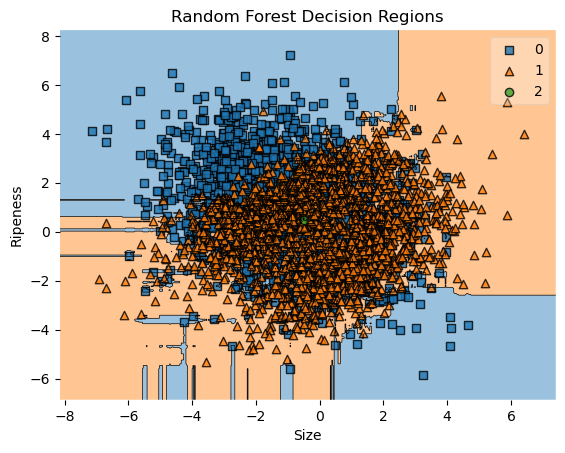

In [48]:
plot_decision_regions(X, y, clf=clf_rf)
plt.xlabel('Size')
plt.ylabel('Ripeness')
plt.title('Random Forest Decision Regions')
plt.show()

In [87]:
X = apples[['Size', 'Sweetness', 'Ripeness']].values
y_encoded = LabelEncoder().fit_transform(apples['Quality'].values)

# Обучение модели случайного леса
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X, y_encoded)

# Важность признаков
feature_importances = rf_clf.feature_importances_

In [88]:
features = ['Size', 'Sweetness', 'Ripeness']
importances = pd.DataFrame({'Feature': features, 'Importance': feature_importances})

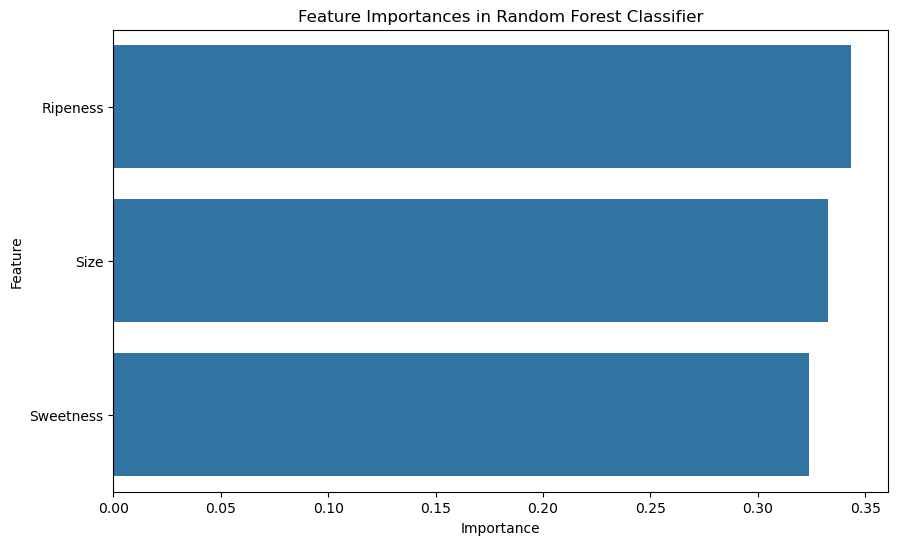

In [89]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importances.sort_values(by='Importance', ascending=False))
plt.title('Feature Importances in Random Forest Classifier')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

In [90]:
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=42)
probabilities = rf_clf.predict_proba(X_test)

In [92]:
prob_class_1 = probabilities[:, 1]
prob_df = pd.DataFrame({'True Label': y_test, 'Probability': prob_class_1})

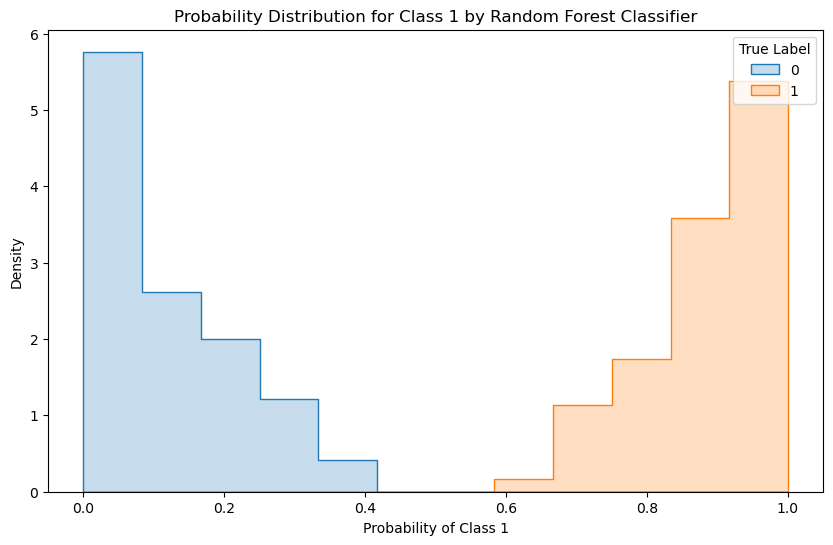

In [93]:
plt.figure(figsize=(10, 6))
sns.histplot(data=prob_df, x='Probability', hue='True Label', element='step', stat='density', common_norm=False)
plt.title('Probability Distribution for Class 1 by Random Forest Classifier')
plt.xlabel('Probability of Class 1')
plt.ylabel('Density')
plt.show()

# Задача 2.3

In [94]:
from mpl_toolkits.mplot3d import Axes3D

In [95]:
sample_data = apples.sample(n=100, random_state=42)

# Извлекаем признаки и метки классов
X_sample = sample_data[['Size', 'Sweetness', 'Ripeness']]
y_sample = LabelEncoder().fit_transform(sample_data['Quality'])

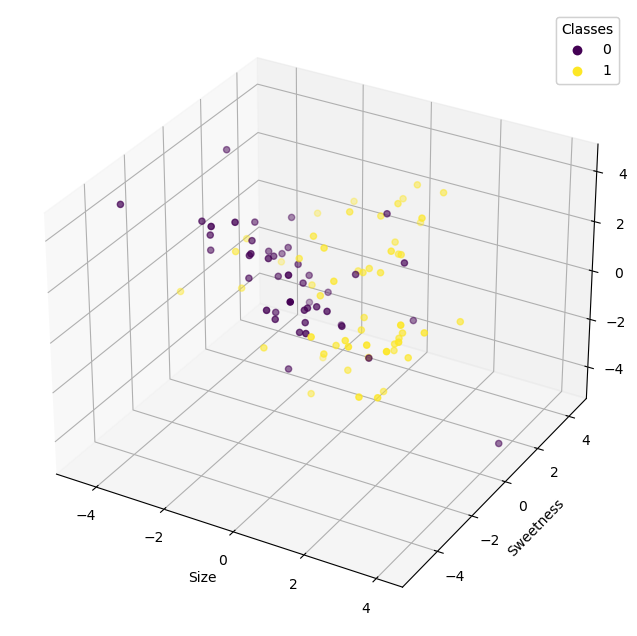

In [98]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X_sample['Size'], X_sample['Sweetness'], X_sample['Ripeness'], c=y_sample, cmap='viridis')

# оси
ax.set_xlabel('Size')
ax.set_ylabel('Sweetness')
ax.set_zlabel('Ripeness')

legend1 = ax.legend(*scatter.legend_elements(), title="Classes")
ax.add_artist(legend1)

plt.show()

# Задача 3

In [99]:
def func(x):
    return x**6 - 3*x**4 + 2*x**2 + 1

def derivative(x):
    return 6*x**5 - 12*x**3 + 4*x

In [100]:
def gradient_descent(starting_point, learning_rate, num_iterations):
    x = starting_point
    x_history = [x]
    f_history = [func(x)]
    
    for _ in range(num_iterations):
        grad = derivative(x)
        x = x - learning_rate * grad
        x_history.append(x)
        f_history.append(func(x))
        
    return x_history, f_history

In [101]:
starting_point = 0.5
learning_rate = 0.02
num_iterations = 25

In [102]:
x_history, f_history = gradient_descent(starting_point, learning_rate, num_iterations)

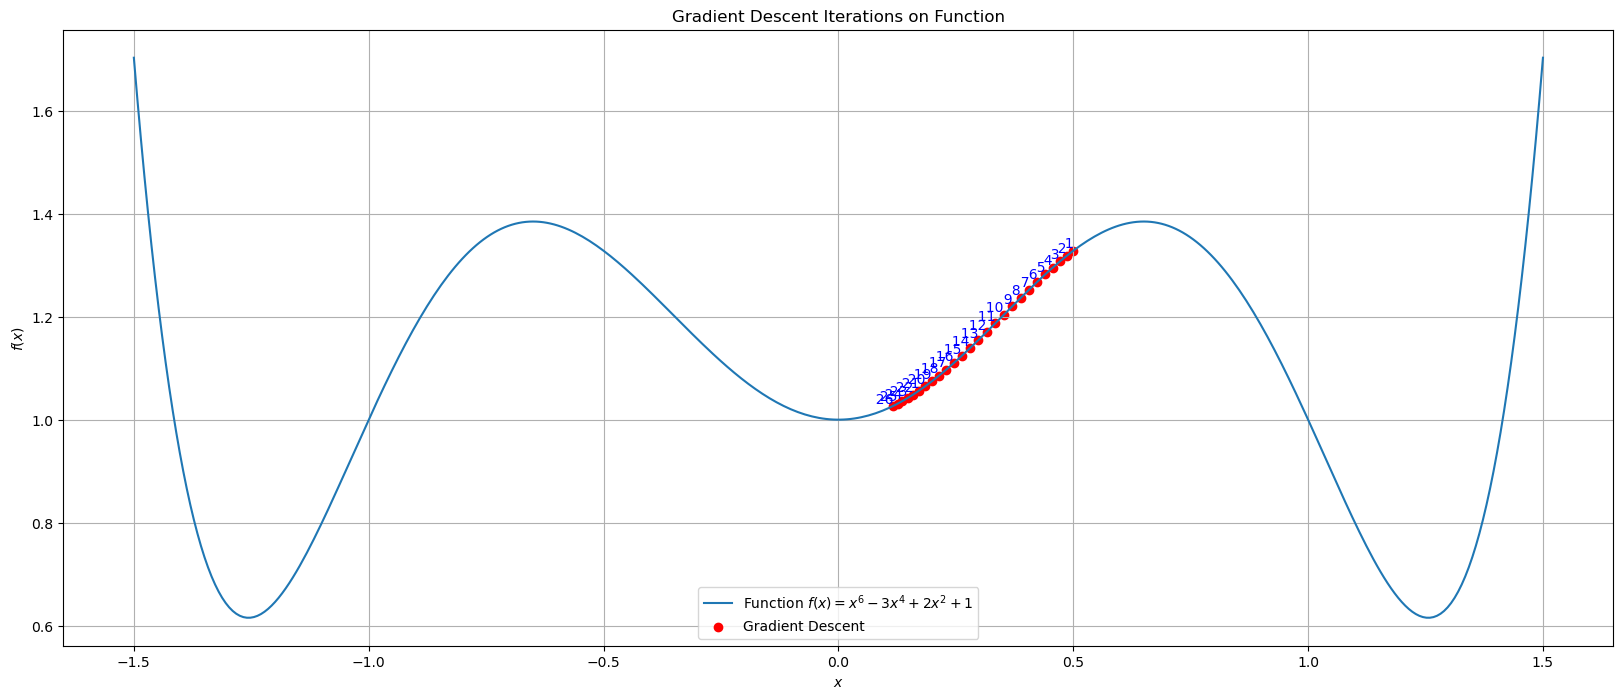

In [107]:
plt.figure(figsize=(20, 8))

# Отрисовка функции
x = np.linspace(-1.5, 1.5, 400)
y = func(x)
plt.plot(x, y, label="Function $f(x) = x^6 - 3x^4 + 2x^2 + 1$")

# Отрисовка итераций градиентного спуска
plt.scatter(x_history, f_history, color='red', label='Gradient Descent')
for i, (x, y) in enumerate(zip(x_history, f_history), start=1):
    plt.text(x, y, f'  {i}', verticalalignment='bottom', horizontalalignment='right', color='blue')

plt.title("Gradient Descent Iterations on Function")
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
plt.legend()
plt.grid(True)
plt.show()

# Задача 4

In [108]:
def rosenbrock(x1, x2):
    """значение ф-ии Розенброка"""
    return (1 - x1)**2 + 100 * (x2 - x1**2)**2

def rosenbrock_gradient(x1, x2):
    """градиент Розенбока"""
    return np.array([-2 * (1 - x1) - 400 * x1 * (x2 - x1**2), 200 * (x2 - x1**2)])

In [109]:
def gradient_descent_rosenbrock(starting_point, learning_rate, num_iterations):
    """градиенттный спуск Розенбока."""
    x1, x2 = starting_point
    x1_history, x2_history = [x1], [x2]
    
    for _ in range(num_iterations):
        grad_x1, grad_x2 = rosenbrock_gradient(x1, x2)
        x1 -= learning_rate * grad_x1
        x2 -= learning_rate * grad_x2
        x1_history.append(x1)
        x2_history.append(x2)
        
    return x1_history, x2_history

In [110]:
starting_point = (-1, -1)
learning_rate = 0.001
num_iterations = 1000

In [112]:
# градиентный спуске
x1_history, x2_history = gradient_descent_rosenbrock(starting_point, learning_rate, num_iterations)

In [113]:
x1_vals = np.linspace(-2, 2, 400)
x2_vals = np.linspace(-1, 3, 400)
x1_vals, x2_vals = np.meshgrid(x1_vals, x2_vals)
z_vals = rosenbrock(x1_vals, x2_vals)

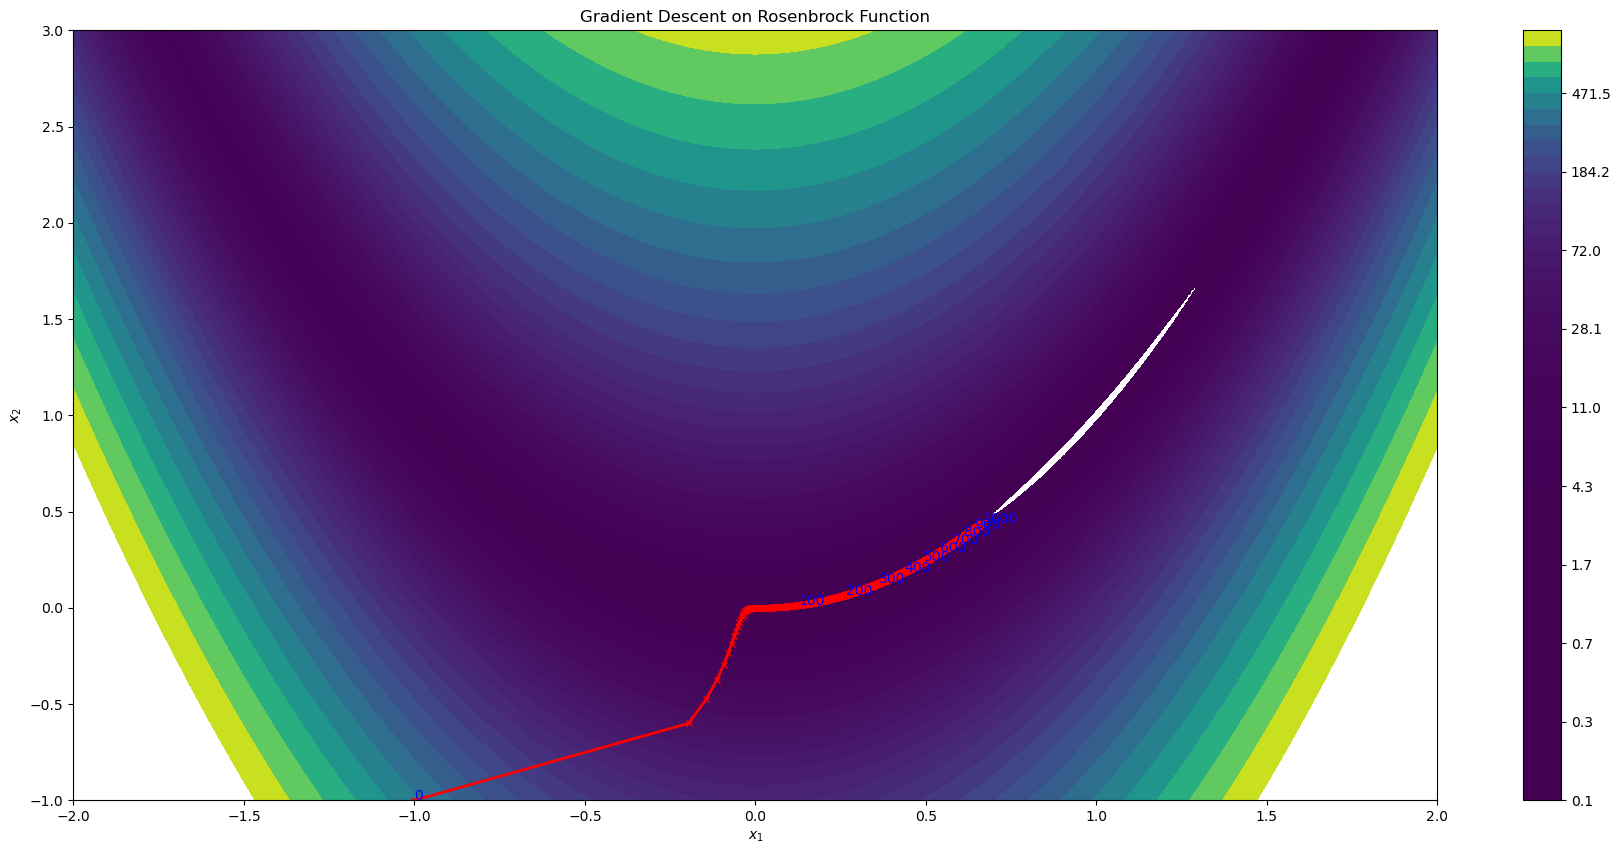

In [115]:
# Визуализация с использованием plt.contourf() и plt.plot()
plt.figure(figsize=(22, 10))

# Контуры уровней функции
contour = plt.contourf(x1_vals, x2_vals, z_vals, cmap='viridis', levels=np.logspace(-1, 3, 50))
plt.colorbar(contour)

# траектория градиентного спуска
plt.plot(x1_history, x2_history, color='r', marker='x', linewidth=2, markersize=5)
plt.title("Gradient Descent on Rosenbrock Function")
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")

for i, (x1, x2) in enumerate(zip(x1_history, x2_history)):
    if i % 100 == 0:  # одпись на каждой 100-й итераци
        plt.text(x1, x2, f'{i}', color='blue')

plt.show()